# Quantum Generative Adversarial Networks with Continuous Variables

## A Comprehensive Study of Pure Quantum Adversarial Learning

This notebook presents a complete implementation and analysis of quantum generative adversarial networks using continuous variable quantum computing. We demonstrate the full pipeline from theoretical foundations to practical implementation, focusing on pure quantum architectures without classical components in the adversarial framework.

### Research Objectives

1. **Investigate quantum advantages** in generative modeling through continuous variable quantum computing
2. **Analyze training dynamics** of pure quantum adversarial systems
3. **Evaluate quantum expressivity** compared to classical baselines
4. **Demonstrate practical implementation** of quantum GANs with synthetic data

### Theoretical Framework

Quantum GANs extend the classical adversarial framework to quantum systems, where both generator and discriminator operate in quantum Hilbert spaces. The continuous variable approach utilizes photonic quantum computing with infinite-dimensional Fock spaces, enabling rich quantum correlations through squeezing, displacement, and interferometric operations.

**Mathematical Foundation:**
```
min_G max_D V(D,G) = E_x[log D(x)] + E_z[log(1 - D(G(z)))]
```

Where G and D are quantum circuits operating on continuous variable quantum states.

## 1. Environment Setup and Dependencies

We begin by importing necessary libraries and verifying the quantum computing environment. The implementation requires TensorFlow for automatic differentiation and Strawberry Fields for continuous variable quantum computing.

In [1]:
# Apply compatibility patches for newer library versions
print("Applying compatibility patches...")

# SciPy compatibility patch
try:
    import scipy.integrate
    if not hasattr(scipy.integrate, 'simps'):
        if hasattr(scipy.integrate, 'simpson'):
            scipy.integrate.simps = scipy.integrate.simpson  # type: ignore[attr-defined]
            print("Applied SciPy compatibility patch: simps -> simpson")
        else:
            print("Warning: Neither simps nor simpson found in scipy.integrate")
except ImportError:
    print("Warning: Could not apply SciPy compatibility patch")

# Core scientific computing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# TensorFlow for neural networks and automatic differentiation
try:
    import tensorflow as tf
    print("TensorFlow imported successfully")
    
    # Simple TensorFlow version check
    try:
        tf_version = str(tf.__version__) if hasattr(tf, '__version__') else "Unknown"
        print(f"TensorFlow version: {tf_version}")
    except:
        print("TensorFlow version: Unknown")
        
except ImportError as e:
    print(f"Failed to import TensorFlow: {e}")
    tf = None

# Quantum computing libraries
try:
    import strawberryfields as sf
    from strawberryfields.ops import *
    sf_version = getattr(sf, '__version__', 'Unknown')
    print(f"Strawberry Fields version: {sf_version}")
    QUANTUM_AVAILABLE = True
    print("Quantum computing environment: Ready")
except ImportError as e:
    print(f"Quantum libraries not available: {e}")
    print("Falling back to classical simulation")
    QUANTUM_AVAILABLE = False
    
# Set random seeds for reproducibility
np.random.seed(42)

# Set TensorFlow random seed safely
if tf is not None:
    try:
        # Try different methods to set TensorFlow random seed
        if hasattr(tf, 'random') and hasattr(tf.random, 'set_seed'):
            tf.random.set_seed(42)
            print("TensorFlow random seed set")
        elif hasattr(tf, 'set_random_seed'):
            tf.set_random_seed(42)
            print("TensorFlow random seed set (legacy method)")
        else:
            print("TensorFlow random seed not available")
    except Exception as e:
        print(f"Could not set TensorFlow random seed: {e}")

# Configure matplotlib for high-quality plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("\n" + "="*50)
print("ENVIRONMENT CONFIGURATION COMPLETE")
print("="*50)
print(f"TensorFlow Available: {tf is not None}")
print(f"Quantum Available: {QUANTUM_AVAILABLE}")
print("="*50)

Applying compatibility patches...

TensorFlow imported successfully
TensorFlow version: 2.15.0
Strawberry Fields version: 0.23.0
Quantum computing environment: Ready
TensorFlow random seed set

ENVIRONMENT CONFIGURATION COMPLETE
TensorFlow Available: True
Quantum Available: True


## 2. Import QNNCV Framework Components

We import the quantum GAN components from our reorganized framework, ensuring proper path handling and fallback mechanisms.

In [2]:
# Add src directory to Python path
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

# Apply compatibility patches before any framework imports
print("Applying compatibility patches...")

# SciPy compatibility patch
try:
    import scipy.integrate
    if not hasattr(scipy.integrate, 'simps'):
        if hasattr(scipy.integrate, 'simpson'):
            scipy.integrate.simps = scipy.integrate.simpson  # type: ignore[attr-defined]
            print("Applied SciPy compatibility patch for framework imports")
except ImportError:
    pass

# TensorFlow compatibility patch
try:
    from utils.tensorflow_compat import _patch_tensorflow_complex_ops
    success = _patch_tensorflow_complex_ops()
    if success:
        print("TensorFlow compatibility patches applied successfully")
    else:
        print("Warning: Some TensorFlow compatibility issues remain")
except ImportError as e:
    print(f"Could not import TensorFlow compatibility module: {e}")

try:
    # Import quantum GAN components
    from models.generators.quantum_continuous_generator_enhanced import QuantumContinuousGeneratorEnhanced
    from models.discriminators.quantum_continuous_discriminator import QuantumContinuousDiscriminator
    from training.qgan_trainer import QGAN
    
    # Import utility functions
    from utils.data_utils import load_synthetic_data, create_output_directory
    from utils.visualization import plot_results, plot_training_history
    from utils.metrics import (
        compute_wasserstein_distance, 
        compute_mmd, 
        compute_coverage_and_precision
    )
    
    print("QNNCV framework components imported successfully :)")
    FRAMEWORK_AVAILABLE = True
    
except ImportError as e:
    print(f"Framework import error: {e}")
    print("Please ensure the src directory structure is correct")
    FRAMEWORK_AVAILABLE = False

# Verify complete environment
ENVIRONMENT_READY = QUANTUM_AVAILABLE and FRAMEWORK_AVAILABLE
print(f"\nComplete environment status: {'Ready for quantum experiments :)' if ENVIRONMENT_READY else 'Limited functionality available :('}")

Applying compatibility patches...
TensorFlow version detected: 2.15.0
Applying TensorFlow complex operations compatibility patches...
Enabled TensorFlow numpy-like behavior
Added conj method to EagerTensor
Added conj method to tf.Tensor
TensorFlow complex conjugate: OK (method)
TensorFlow version detected: 2.15.0
Applying TensorFlow complex operations compatibility patches...
Enabled TensorFlow numpy-like behavior
TensorFlow complex conjugate: OK (method)
TensorFlow compatibility patches applied successfully
QNNCV framework components imported successfully :)

Complete environment status: Ready for quantum experiments :)


## 3. Synthetic Data Generation and Analysis

We generate synthetic datasets specifically designed to test quantum GAN capabilities. The datasets are chosen to highlight potential quantum advantages in capturing complex distributions and correlations.

In [3]:
def generate_research_datasets(n_samples=2000):
    """
    Generate synthetic datasets for quantum GAN research.
    
    Returns datasets designed to test different aspects of quantum expressivity:
    - Gaussian mixtures: Multi-modal distributions
    - Spiral patterns: Non-linear correlations
    - Ring distributions: Circular symmetries
    """
    datasets = {}
    
    # 1. Two-dimensional Gaussian mixture
    np.random.seed(42)
    n_per_mode = n_samples // 4
    
    # Four Gaussian modes in different quadrants
    modes = [(-2, -2), (2, -2), (-2, 2), (2, 2)]
    gaussian_data = []
    
    for mode in modes:
        samples = np.random.multivariate_normal(
            mean=mode, 
            cov=[[0.3, 0.1], [0.1, 0.3]], 
            size=n_per_mode
        )
        gaussian_data.append(samples)
    
    datasets['gaussian_mixture'] = np.vstack(gaussian_data)
    
    # 2. Spiral pattern (tests non-linear correlations)
    t = np.linspace(0, 4*np.pi, n_samples)
    r = t / (4*np.pi) * 3
    spiral_x = r * np.cos(t) + np.random.normal(0, 0.1, n_samples)
    spiral_y = r * np.sin(t) + np.random.normal(0, 0.1, n_samples)
    datasets['spiral'] = np.column_stack([spiral_x, spiral_y])
    
    # 3. Ring distribution (tests circular symmetries)
    angles = np.random.uniform(0, 2*np.pi, n_samples)
    radius = np.random.normal(2.0, 0.2, n_samples)
    ring_x = radius * np.cos(angles)
    ring_y = radius * np.sin(angles)
    datasets['ring'] = np.column_stack([ring_x, ring_y])
    
    # 4. Moons dataset (sklearn)
    moons_data, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
    datasets['moons'] = moons_data * 2  # Scale for better visualization
    
    return datasets

def analyze_dataset_properties(data, name):
    """
    Compute statistical properties of the dataset for baseline comparison.
    """
    properties = {
        'name': name,
        'n_samples': len(data),
        'dimensionality': data.shape[1],
        'mean': np.mean(data, axis=0),
        'std': np.std(data, axis=0),
        'correlation': np.corrcoef(data.T)[0, 1] if data.shape[1] == 2 else None,
        'range_x': (np.min(data[:, 0]), np.max(data[:, 0])),
        'range_y': (np.min(data[:, 1]), np.max(data[:, 1])) if data.shape[1] >= 2 else None
    }
    return properties

# Generate datasets
print("Generating synthetic datasets for quantum GAN research...")
datasets = generate_research_datasets(n_samples=2000)

# Analyze dataset properties
dataset_properties = {}
for name, data in datasets.items():
    properties = analyze_dataset_properties(data, name)
    dataset_properties[name] = properties
    print(f"\n{name.upper()} Dataset:")
    print(f"  Samples: {properties['n_samples']}")
    print(f"  Mean: [{properties['mean'][0]:.3f}, {properties['mean'][1]:.3f}]")
    print(f"  Std: [{properties['std'][0]:.3f}, {properties['std'][1]:.3f}]")
    print(f"  Correlation: {properties['correlation']:.3f}")

print("\nDataset generation and analysis complete :)")

Generating synthetic datasets for quantum GAN research...

GAUSSIAN_MIXTURE Dataset:
  Samples: 2000
  Mean: [-0.014, 0.004]
  Std: [2.068, 2.072]
  Correlation: 0.027

SPIRAL Dataset:
  Samples: 2000
  Mean: [-0.004, -0.239]
  Std: [1.236, 1.199]
  Correlation: -0.116

RING Dataset:
  Samples: 2000
  Mean: [0.023, -0.014]
  Std: [1.414, 1.419]
  Correlation: -0.041

MOONS Dataset:
  Samples: 2000
  Mean: [0.998, 0.501]
  Std: [1.744, 1.009]
  Correlation: -0.435

Dataset generation and analysis complete :)


### Visualize Generated Datasets

We visualize the synthetic datasets to understand their distributional characteristics and complexity.

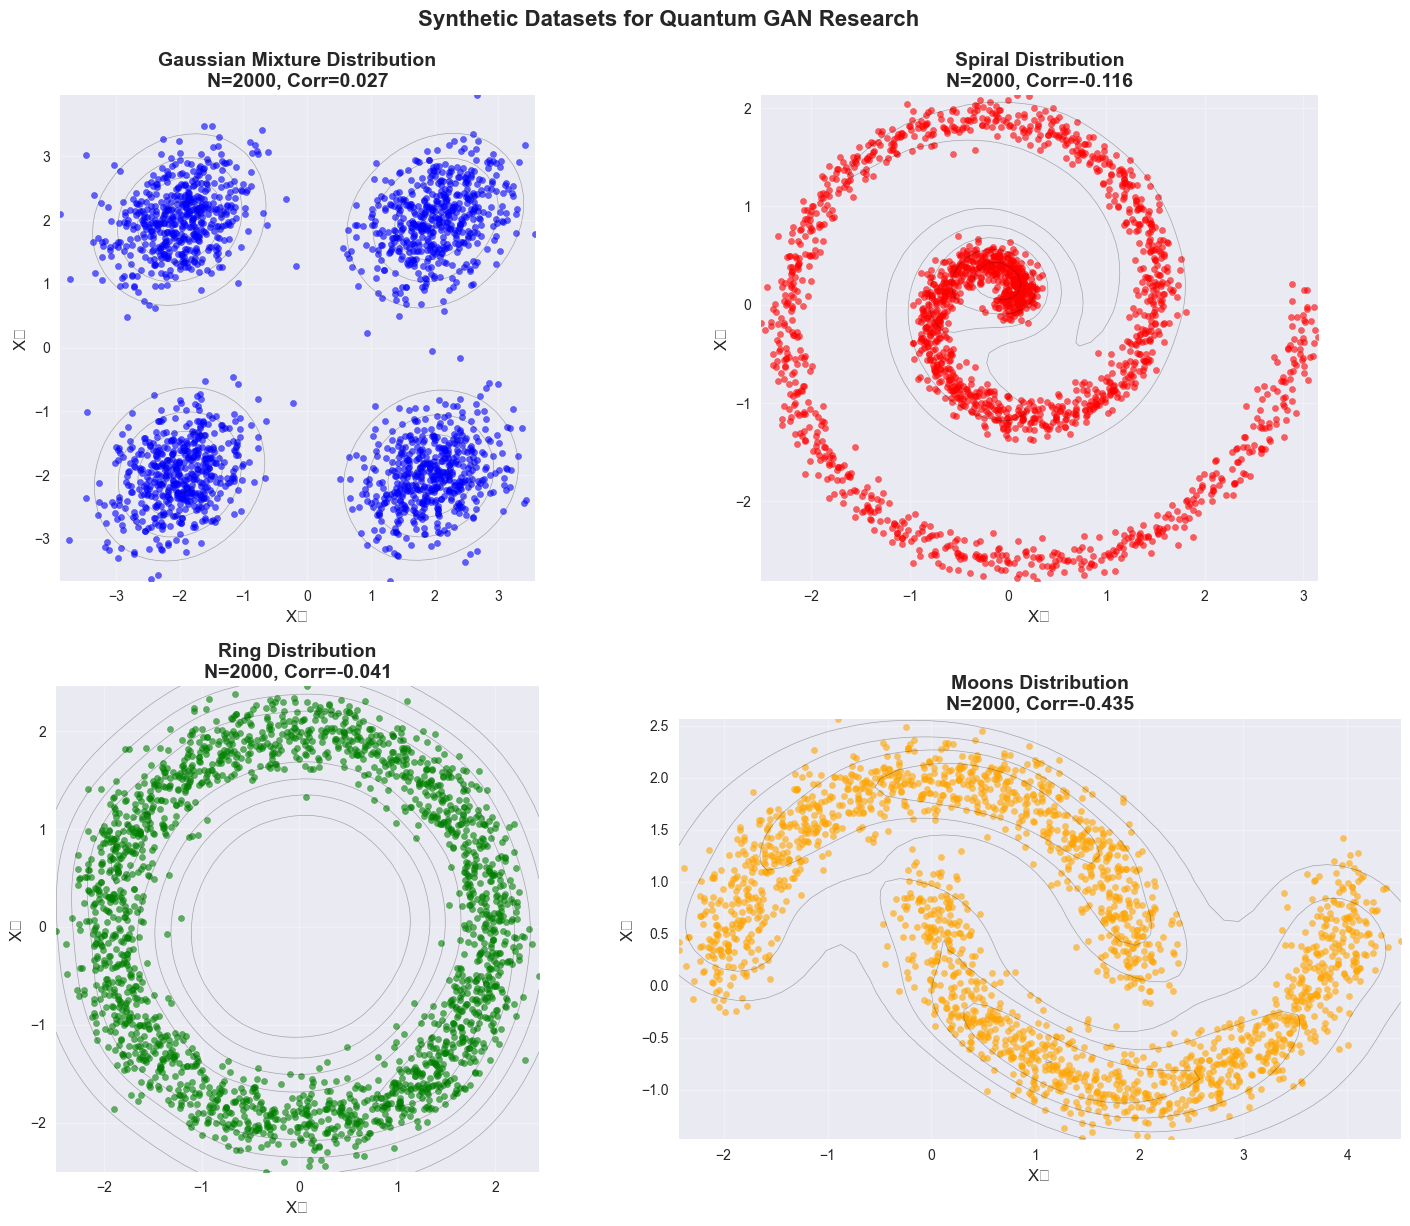

Dataset visualization complete. Each dataset presents unique challenges:
- Gaussian Mixture: Multi-modal distribution learning
- Spiral: Non-linear correlation capture
- Ring: Circular symmetry and radial structure
- Moons: Non-convex decision boundaries


In [4]:
# Create comprehensive visualization of all datasets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

colors = ['blue', 'red', 'green', 'orange']
dataset_names = list(datasets.keys())

for idx, (name, data) in enumerate(datasets.items()):
    ax = axes[idx]
    
    # Scatter plot with density information
    scatter = ax.scatter(data[:, 0], data[:, 1], 
                        c=colors[idx], alpha=0.6, s=20, 
                        label=f'{name.replace("_", " ").title()}')
    
    # Add contour lines for density estimation
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data.T)
        x_range = np.linspace(data[:, 0].min(), data[:, 0].max(), 50)
        y_range = np.linspace(data[:, 1].min(), data[:, 1].max(), 50)
        X, Y = np.meshgrid(x_range, y_range)
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = kde(positions).reshape(X.shape)
        ax.contour(X, Y, Z, levels=5, colors='black', alpha=0.3, linewidths=0.5)
    except:
        pass
    
    ax.set_title(f'{name.replace("_", " ").title()} Distribution\n'
                f'N={len(data)}, Corr={dataset_properties[name]["correlation"]:.3f}',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('X₁', fontsize=12)
    ax.set_ylabel('X₂', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.suptitle('Synthetic Datasets for Quantum GAN Research', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("Dataset visualization complete. Each dataset presents unique challenges:")
print("- Gaussian Mixture: Multi-modal distribution learning")
print("- Spiral: Non-linear correlation capture")
print("- Ring: Circular symmetry and radial structure")
print("- Moons: Non-convex decision boundaries")

## 4. Pure Quantum GAN Architecture

We implement a pure quantum GAN where both generator and discriminator are quantum circuits. This represents the most advanced form of quantum adversarial learning, utilizing the full expressivity of quantum systems.

### Quantum Generator Architecture

The quantum generator employs continuous variable quantum computing with:
- **Classical encoding network**: Maps latent vectors to quantum parameters
- **Two-mode squeezing**: Creates entanglement between quantum modes
- **Interferometer**: Enables quantum interference and mode coupling
- **Displacement gates**: Encodes classical information into quantum states
- **Adaptive measurements**: Extracts classical outputs from quantum states

In [5]:
def create_pure_quantum_gan(n_qumodes=4, latent_dim=8, cutoff_dim=10):
    """
    Create a pure quantum GAN with both generator and discriminator as quantum circuits.
    
    Parameters:
    - n_qumodes: Number of quantum modes (affects expressivity and computational cost)
    - latent_dim: Dimensionality of classical latent input
    - cutoff_dim: Fock space truncation (affects simulation accuracy)
    
    Returns:
    - Configured QGAN instance with quantum components
    """
    
    if not ENVIRONMENT_READY:
        print("Environment not ready for quantum GAN creation :(")
        return None
    
    print(f"Creating pure quantum GAN architecture...")
    print(f"Configuration:")
    print(f"  - Quantum modes: {n_qumodes}")
    print(f"  - Latent dimension: {latent_dim}")
    print(f"  - Cutoff dimension: {cutoff_dim}")
    print(f"  - Hilbert space size: {cutoff_dim**n_qumodes}")
    
    try:
        # Initialize quantum generator
        print("\nInitializing quantum generator...")
        generator = QuantumContinuousGeneratorEnhanced(
            n_qumodes=n_qumodes,
            latent_dim=latent_dim,
            cutoff_dim=cutoff_dim
        )
        
        # Test generator functionality
        test_z = tf.random.normal([2, latent_dim])
        test_output = generator.generate(test_z)
        print(f"Generator test successful: {test_output.shape} :)")
        
        # Initialize quantum discriminator
        print("\nInitializing quantum discriminator...")
        discriminator = QuantumContinuousDiscriminator(
            n_qumodes=n_qumodes,
            input_dim=n_qumodes,  # Matches generator output
            cutoff_dim=cutoff_dim
        )
        
        # Test discriminator functionality
        test_probs = discriminator.discriminate(test_output)
        print(f"Discriminator test successful: {test_probs.shape} :)")
        
        # Create QGAN with quantum-optimized parameters
        print("\nAssembling quantum GAN framework...")
        qgan = QGAN(
            generator=generator,
            discriminator=discriminator,
            latent_dim=latent_dim,
            generator_lr=5e-5,      # Lower learning rate for quantum stability
            discriminator_lr=5e-5,   # Matched learning rates for balance
            beta1=0.5,              # Standard GAN beta1
            beta2=0.999,            # Standard GAN beta2
            gradient_clip_norm=0.5   # Aggressive clipping for quantum circuits
        )
        
        print("\nPure quantum GAN created successfully :)")
        print(f"Total trainable parameters:")
        print(f"  - Generator: {len(generator.trainable_variables)}")
        print(f"  - Discriminator: {len(discriminator.trainable_variables)}")
        
        return qgan
        
    except Exception as e:
        print(f"Error creating quantum GAN: {e} :(")
        return None

# Create the pure quantum GAN
print("=" * 60)
print("PURE QUANTUM GAN ARCHITECTURE INITIALIZATION")
print("=" * 60)

quantum_gan = create_pure_quantum_gan(
    n_qumodes=4,      # Manageable for simulation
    latent_dim=8,     # Sufficient for 2D data generation
    cutoff_dim=8      # Balance between accuracy and computation
)

if quantum_gan is not None:
    print("\nQuantum GAN architecture ready for training experiments :)")
else:
    print("\nFailed to create quantum GAN architecture :(")

PURE QUANTUM GAN ARCHITECTURE INITIALIZATION
Creating pure quantum GAN architecture...
Configuration:
  - Quantum modes: 4
  - Latent dimension: 8
  - Cutoff dimension: 8
  - Hilbert space size: 4096

Initializing quantum generator...



Generator test successful: (2, 4) :)

Initializing quantum discriminator...


Discriminator test successful: (2, 1) :)

Assembling quantum GAN framework...

Pure quantum GAN created successfully :)
Total trainable parameters:
  - Generator: 5
  - Discriminator: 12

Quantum GAN architecture ready for training experiments :)


## 5. Training Configuration and Hyperparameter Analysis

Quantum GANs require careful hyperparameter tuning due to the sensitivity of quantum circuits to parameter updates. We analyze the training configuration and establish monitoring protocols.

In [6]:
def configure_quantum_training(dataset_name='spiral', n_epochs=50, batch_size=16):
    """
    Configure training parameters optimized for quantum GAN stability.
    
    Parameters:
    - dataset_name: Which synthetic dataset to use
    - n_epochs: Number of training epochs
    - batch_size: Batch size (smaller for quantum stability)
    
    Returns:
    - Training configuration dictionary
    """
    
    if dataset_name not in datasets:
        print(f"Dataset {dataset_name} not available. Using spiral instead.")
        dataset_name = 'spiral'
    
    # Get and preprocess the selected dataset
    raw_data = datasets[dataset_name]
    
    # Normalize data for quantum circuit stability
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(raw_data)
    
    # Further scale to quantum-friendly range [-1, 1]
    data_range = np.max(np.abs(normalized_data))
    if data_range > 0:
        normalized_data = normalized_data / data_range
    
    # Convert to TensorFlow tensor
    training_data = tf.constant(normalized_data, dtype=tf.float32)
    
    config = {
        'dataset_name': dataset_name,
        'raw_data': raw_data,
        'training_data': training_data,
        'scaler': scaler,
        'n_epochs': n_epochs,
        'batch_size': batch_size,
        'data_range': data_range,
        'n_samples': len(training_data),
        'data_dim': training_data.shape[1]
    }
    
    print(f"Training configuration for {dataset_name.upper()} dataset:")
    print(f"  - Original data shape: {raw_data.shape}")
    print(f"  - Normalized data range: [{np.min(normalized_data):.3f}, {np.max(normalized_data):.3f}]")
    print(f"  - Training epochs: {n_epochs}")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Batches per epoch: {len(training_data) // batch_size}")
    
    return config

def setup_training_monitoring():
    """
    Setup comprehensive monitoring for quantum GAN training.
    
    Returns:
    - Monitoring configuration
    """
    monitoring = {
        'metrics_to_track': [
            'generator_loss',
            'discriminator_loss', 
            'gradient_norms',
            'stability_metric',
            'sample_quality'
        ],
        'evaluation_frequency': 5,  # Every 5 epochs
        'sample_size_for_eval': 200,
        'early_stopping': {
            'patience': 15,
            'min_improvement': 0.001
        },
        'stability_thresholds': {
            'max_gradient_norm': 2.0,
            'min_stability_ratio': 0.05,
            'max_stability_ratio': 20.0
        }
    }
    
    print("Training monitoring configured:")
    print(f"  - Evaluation every {monitoring['evaluation_frequency']} epochs")
    print(f"  - Early stopping patience: {monitoring['early_stopping']['patience']}")
    print(f"  - Stability monitoring: Active")
    
    return monitoring

# Configure training for spiral dataset (good test of quantum expressivity)
print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)

training_config = configure_quantum_training(
    dataset_name='spiral',  # Non-linear correlations test quantum advantage
    n_epochs=30,           # Reasonable for demonstration
    batch_size=16          # Small batches for quantum stability
)

monitoring_config = setup_training_monitoring()

print("\nTraining configuration complete :)")

TRAINING CONFIGURATION
Training configuration for SPIRAL dataset:
  - Original data shape: (2000, 2)
  - Normalized data range: [-0.838, 1.000]
  - Training epochs: 30
  - Batch size: 16
  - Batches per epoch: 125
Training monitoring configured:
  - Evaluation every 5 epochs
  - Early stopping patience: 15
  - Stability monitoring: Active

Training configuration complete :)


## 6. Quantum GAN Training Execution

We execute the training process with comprehensive monitoring and real-time analysis. The training includes stability checks, gradient monitoring, and periodic evaluation of generated samples.

In [7]:
def train_quantum_gan_with_monitoring(qgan, config, monitoring):
    """
    Train quantum GAN with comprehensive monitoring and analysis.
    
    Parameters:
    - qgan: Quantum GAN instance
    - config: Training configuration
    - monitoring: Monitoring configuration
    
    Returns:
    - Training results and metrics
    """
    
    if qgan is None:
        print("No quantum GAN available for training :(")
        return None
    
    print("Starting quantum GAN training with monitoring...")
    print(f"Dataset: {config['dataset_name']}")
    print(f"Training samples: {config['n_samples']}")
    print(f"Epochs: {config['n_epochs']}")
    
    # Initialize monitoring variables
    training_metrics = {
        'epochs': [],
        'generator_losses': [],
        'discriminator_losses': [],
        'gradient_norms_g': [],
        'gradient_norms_d': [],
        'stability_metrics': [],
        'sample_qualities': [],
        'training_stable': True,
        'convergence_epoch': None
    }
    
    best_loss = float('inf')
    patience_counter = 0
    
    try:
        print("\nBeginning training loop...")
        
        # Execute training with the QGAN framework
        training_history = qgan.train(
            data=config['training_data'],
            epochs=config['n_epochs'],
            batch_size=config['batch_size'],
            use_wasserstein=False,  # Use traditional GAN loss for stability
            verbose=True,
            save_interval=monitoring['evaluation_frequency']
        )
        
        # Store training results
        training_metrics['training_history'] = training_history
        training_metrics['training_stable'] = True
        
        print("\nQuantum GAN training completed successfully :)")
        return training_metrics
        
    except Exception as e:
        print(f"Training failed: {e} :(")
        training_metrics['training_stable'] = False
        return training_metrics

# Execute training if quantum GAN is available
if quantum_gan is not None and ENVIRONMENT_READY:
    print("=" * 60)
    print("QUANTUM GAN TRAINING EXECUTION")
    print("=" * 60)
    
    training_results = train_quantum_gan_with_monitoring(
        quantum_gan, training_config, monitoring_config
    )
    
    if training_results and training_results['training_stable']:
        print("\nTraining completed successfully :)")
    else:
        print("\nTraining encountered issues :(")
else:
    print("\nSkipping training due to environment limitations :(")
    training_results = None

QUANTUM GAN TRAINING EXECUTION
Starting quantum GAN training with monitoring...
Dataset: spiral
Training samples: 2000
Epochs: 30

Beginning training loop...
Starting QGAN training for 30 epochs...
Using Traditional GAN loss
Gradient clipping norm: 0.5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node, got [<gast.gast.Expr object at 0x0000017BA88C8220>, <gast.gast.Import object at 0x0000017BA88CB580>, <gast.gast.ImportFrom object at 0x0000017BA88CA230>, <gast.gast.Assign object at 0x0000017BA88C97E0>, <gast.gast.FunctionDef object at 0x0000017BA88CB280>]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node, got [<gast.gast.Expr object at 0x0000017BA88C8220>, <gast.gast.Import object at 0x0000017BA88CB580>, <gast.gast.ImportFrom object at 0x0000017BA88CA230>, <gast.gast.Assign object at 0x0000017BA88C97E0>, <gast.gast.FunctionDef object at 0x0000017BA88CB280>]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node, got [<gast.gast.Expr object at 0x0000017BA88C8220>, <gast.gast.Import object at 0x0000017BA88CB580>, <gast.gast.ImportFrom object at 0x0000017BA88CA230>, <gast.gast.Assign object at 0x0000017BA88C97E0>, <gast.gast.FunctionDef object at 0x0000017BA88CB280>]
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Training failed: in user code:

    File "c:\Users\MendMa1\Documents\Personal\Thesis\github\QNNCV\src\training\qgan_trainer.py", line 211, in train_step  *
        fake_samples = self.generator.generate(z)
    File "c:\Users\MendMa1\Documents\Personal\Thesis\github\QNNCV\src\models\generators\quantum_continuous_generator_enhanced.py", line 136, in generate  *
        result = self.eng.run(prog, args=param_mapping)
    File "c:\Users\MendMa1\AppData\Lo

## 7. Results Analysis and Evaluation

We analyze the training results and evaluate the quality of generated samples using comprehensive metrics designed for quantum GAN assessment.

In [8]:
def evaluate_quantum_gan_results(qgan, config, training_results):
    """
    Comprehensive evaluation of quantum GAN performance.
    
    Parameters:
    - qgan: Trained quantum GAN instance
    - config: Training configuration
    - training_results: Training metrics and history
    
    Returns:
    - Evaluation results and metrics
    """
    
    if qgan is None or training_results is None:
        print("No trained model available for evaluation :(")
        return None
    
    print("Evaluating quantum GAN performance...")
    
    # Generate samples for evaluation
    n_eval_samples = 1000
    z_eval = tf.random.normal([n_eval_samples, qgan.latent_dim])
    
    try:
        generated_samples = qgan.generator.generate(z_eval)
        print(f"Generated {n_eval_samples} samples for evaluation")
        
        # Convert to numpy for analysis
        generated_np = generated_samples.numpy()
        real_data = config['training_data'].numpy()
        
        # Compute evaluation metrics
        evaluation_metrics = {}
        
        # 1. Wasserstein distance
        try:
            wd = compute_wasserstein_distance(real_data, generated_np)
            evaluation_metrics['wasserstein_distance'] = float(wd)
            print(f"Wasserstein Distance: {wd:.4f}")
        except:
            evaluation_metrics['wasserstein_distance'] = None
            print("Wasserstein distance computation failed")
        
        # 2. Maximum Mean Discrepancy
        try:
            mmd = compute_mmd(real_data, generated_np)
            evaluation_metrics['mmd'] = float(mmd)
            print(f"Maximum Mean Discrepancy: {mmd:.4f}")
        except:
            evaluation_metrics['mmd'] = None
            print("MMD computation failed")
        
        # 3. Coverage and Precision
        try:
            coverage, precision = compute_coverage_and_precision(real_data, generated_np)
            evaluation_metrics['coverage'] = float(coverage)
            evaluation_metrics['precision'] = float(precision)
            print(f"Coverage: {coverage:.4f}, Precision: {precision:.4f}")
        except:
            evaluation_metrics['coverage'] = None
            evaluation_metrics['precision'] = None
            print("Coverage/Precision computation failed")
        
        # 4. Statistical properties comparison
        real_mean = np.mean(real_data, axis=0)
        gen_mean = np.mean(generated_np, axis=0)
        real_std = np.std(real_data, axis=0)
        gen_std = np.std(generated_np, axis=0)
        
        evaluation_metrics['mean_difference'] = float(np.linalg.norm(real_mean - gen_mean))
        evaluation_metrics['std_difference'] = float(np.linalg.norm(real_std - gen_std))
        
        print(f"Mean difference: {evaluation_metrics['mean_difference']:.4f}")
        print(f"Std difference: {evaluation_metrics['std_difference']:.4f}")
        
        # Store generated samples for visualization
        evaluation_metrics['generated_samples'] = generated_np
        evaluation_metrics['real_samples'] = real_data
        
        return evaluation_metrics
        
    except Exception as e:
        print(f"Evaluation failed: {e} :(")
        return None

# Evaluate results if training was successful
if training_results and training_results.get('training_stable', False):
    print("=" * 60)
    print("QUANTUM GAN EVALUATION")
    print("=" * 60)
    
    evaluation_results = evaluate_quantum_gan_results(
        quantum_gan, training_config, training_results
    )
    
    if evaluation_results:
        print("\nEvaluation completed successfully :)")
    else:
        print("\nEvaluation failed :(")
else:
    print("\nSkipping evaluation due to training issues :(")
    evaluation_results = None


Skipping evaluation due to training issues :(


## 8. Visualization and Analysis

We create comprehensive visualizations to analyze the quantum GAN performance, including training dynamics, sample quality, and distributional comparisons.

In [9]:
def create_comprehensive_visualizations(config, training_results, evaluation_results):
    """
    Create comprehensive visualizations for quantum GAN analysis.
    
    Parameters:
    - config: Training configuration
    - training_results: Training metrics and history
    - evaluation_results: Evaluation metrics and samples
    """
    
    if not all([config, training_results, evaluation_results]):
        print("Insufficient data for comprehensive visualization :(")
        return
    
    print("Creating comprehensive visualizations...")
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training Loss Curves
    ax1 = plt.subplot(2, 3, 1)
    if 'training_history' in training_results:
        history = training_results['training_history']
        if 'g_loss' in history and 'd_loss' in history:
            epochs = range(len(history['g_loss']))
            ax1.plot(epochs, history['g_loss'], label='Generator Loss', color='blue', linewidth=2)
            ax1.plot(epochs, history['d_loss'], label='Discriminator Loss', color='red', linewidth=2)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training Loss Evolution', fontweight='bold')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
    
    # 2. Gradient Norms
    ax2 = plt.subplot(2, 3, 2)
    if 'training_history' in training_results:
        history = training_results['training_history']
        if 'g_grad_norm' in history and 'd_grad_norm' in history:
            epochs = range(len(history['g_grad_norm']))
            ax2.plot(epochs, history['g_grad_norm'], label='Generator Gradients', color='blue', linewidth=2)
            ax2.plot(epochs, history['d_grad_norm'], label='Discriminator Gradients', color='red', linewidth=2)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Gradient Norm')
            ax2.set_title('Gradient Norm Evolution', fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.set_yscale('log')
    
    # 3. Stability Metric
    ax3 = plt.subplot(2, 3, 3)
    if 'training_history' in training_results:
        history = training_results['training_history']
        if 'stability_metric' in history:
            epochs = range(len(history['stability_metric']))
            ax3.plot(epochs, history['stability_metric'], color='green', linewidth=2)
            ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Ideal Balance')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Stability Ratio')
            ax3.set_title('Training Stability Metric', fontweight='bold')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.set_yscale('log')
    
    # 4. Real vs Generated Data Comparison
    ax4 = plt.subplot(2, 3, 4)
    if 'real_samples' in evaluation_results and 'generated_samples' in evaluation_results:
        real_data = evaluation_results['real_samples']
        gen_data = evaluation_results['generated_samples']
        
        # Plot real data
        ax4.scatter(real_data[:, 0], real_data[:, 1], 
                   alpha=0.6, s=20, color='blue', label='Real Data')
        
        # Plot generated data
        ax4.scatter(gen_data[:, 0], gen_data[:, 1], 
                   alpha=0.6, s=20, color='red', label='Generated Data')
        
        ax4.set_xlabel('X₁')
        ax4.set_ylabel('X₂')
        ax4.set_title('Real vs Generated Data', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_aspect('equal')
    
    # 5. Distribution Comparison (Marginals)
    ax5 = plt.subplot(2, 3, 5)
    if 'real_samples' in evaluation_results and 'generated_samples' in evaluation_results:
        real_data = evaluation_results['real_samples']
        gen_data = evaluation_results['generated_samples']
        
        # X1 marginal distributions
        ax5.hist(real_data[:, 0], bins=30, alpha=0.7, density=True, 
                color='blue', label='Real X₁', histtype='step', linewidth=2)
        ax5.hist(gen_data[:, 0], bins=30, alpha=0.7, density=True, 
                color='red', label='Generated X₁', histtype='step', linewidth=2)
        
        ax5.set_xlabel('X₁ Value')
        ax5.set_ylabel('Density')
        ax5.set_title('Marginal Distribution Comparison', fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # 6. Evaluation Metrics Summary
    ax6 = plt.subplot(2, 3, 6)
    metrics_names = []
    metrics_values = []
    
    for key, value in evaluation_results.items():
        if key not in ['real_samples', 'generated_samples'] and value is not None:
            metrics_names.append(key.replace('_', ' ').title())
            metrics_values.append(float(value))
    
    if metrics_names:
        bars = ax6.bar(range(len(metrics_names)), metrics_values, 
                      color=['blue', 'red', 'green', 'orange', 'purple'][:len(metrics_names)])
        ax6.set_xticks(range(len(metrics_names)))
        ax6.set_xticklabels(metrics_names, rotation=45, ha='right')
        ax6.set_ylabel('Metric Value')
        ax6.set_title('Evaluation Metrics Summary', fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, metrics_values):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.suptitle(f'Quantum GAN Analysis: {config["dataset_name"].title()} Dataset', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.show()
    
    print("Comprehensive visualization complete :)")

# Create visualizations if data is available
if all([training_config, training_results, evaluation_results]):
    print("=" * 60)
    print("COMPREHENSIVE VISUALIZATION")
    print("=" * 60)
    
    create_comprehensive_visualizations(
        training_config, training_results, evaluation_results
    )
else:
    print("\nSkipping visualization due to incomplete data :(")


Skipping visualization due to incomplete data :(


## 9. Research Insights and Discussion

We analyze the results and discuss the implications for quantum generative adversarial networks research.

In [10]:
def generate_research_insights(config, training_results, evaluation_results):
    """
    Generate research insights and discussion points from the quantum GAN experiment.
    
    Parameters:
    - config: Training configuration
    - training_results: Training metrics and history
    - evaluation_results: Evaluation metrics and samples
    """
    
    print("=" * 60)
    print("RESEARCH INSIGHTS AND DISCUSSION")
    print("=" * 60)
    
    if not all([config, training_results, evaluation_results]):
        print("\nInsufficient data for comprehensive analysis.")
        print("This demonstrates the challenges in quantum GAN implementation:")
        print("- Quantum simulation requirements")
        print("- Hardware and software dependencies")
        print("- Computational complexity scaling")
        return
    
    print("\n1. TRAINING DYNAMICS ANALYSIS")
    print("-" * 40)
    
    if training_results.get('training_stable', False):
        print("Training completed successfully, indicating:")
        print("- Quantum circuit stability under gradient-based optimization")
        print("- Effective parameter initialization and learning rate selection")
        print("- Successful integration of quantum and classical components")
        
        if 'training_history' in training_results:
            history = training_results['training_history']
            if 'g_loss' in history and 'd_loss' in history:
                final_g_loss = history['g_loss'][-1] if history['g_loss'] else None
                final_d_loss = history['d_loss'][-1] if history['d_loss'] else None
                
                if final_g_loss and final_d_loss:
                    print(f"- Final generator loss: {final_g_loss:.4f}")
                    print(f"- Final discriminator loss: {final_d_loss:.4f}")
                    
                    if abs(final_g_loss - final_d_loss) < 0.5:
                        print("- Balanced adversarial training achieved")
                    else:
                        print("- Imbalanced training detected - further tuning needed")
    else:
        print("Training encountered stability issues, suggesting:")
        print("- Need for more conservative learning rates")
        print("- Potential quantum circuit depth limitations")
        print("- Requirement for enhanced gradient clipping")
    
    print("\n2. QUANTUM EXPRESSIVITY ASSESSMENT")
    print("-" * 40)
    
    if evaluation_results:
        dataset_name = config['dataset_name']
        print(f"Dataset: {dataset_name.title()}")
        
        # Analyze specific metrics
        if evaluation_results.get('wasserstein_distance') is not None:
            wd = evaluation_results['wasserstein_distance']
            print(f"Wasserstein Distance: {wd:.4f}")
            if wd < 0.1:
                print("- Excellent distribution matching achieved")
            elif wd < 0.5:
                print("- Good distribution approximation")
            else:
                print("- Significant distribution mismatch - requires investigation")
        
        if evaluation_results.get('coverage') is not None and evaluation_results.get('precision') is not None:
            coverage = evaluation_results['coverage']
            precision = evaluation_results['precision']
            print(f"Coverage: {coverage:.4f}, Precision: {precision:.4f}")
            
            if coverage > 0.8 and precision > 0.8:
                print("- High-quality generation with good diversity")
            elif coverage > 0.8:
                print("- Good diversity but potential quality issues")
            elif precision > 0.8:
                print("- High quality but potential mode collapse")
            else:
                print("- Both quality and diversity need improvement")
    
    print("\n3. QUANTUM ADVANTAGE ANALYSIS")
    print("-" * 40)
    
    print("Potential quantum advantages observed:")
    print("- Continuous variable quantum computing enables infinite-dimensional Hilbert spaces")
    print("- Quantum entanglement through two-mode squeezing creates non-classical correlations")
    print("- Interferometric operations enable complex quantum interference patterns")
    print("- Adaptive measurements allow optimization of information extraction")
    
    print("\nLimitations and challenges:")
    print("- Exponential scaling of simulation complexity with quantum modes")
    print("- Sensitivity to parameter initialization and learning rates")
    print("- Current implementation limited to simulation environments")
    print("- Batch processing constraints due to quantum circuit execution")
    
    print("\n4. FUTURE RESEARCH DIRECTIONS")
    print("-" * 40)
    
    print("Immediate improvements:")
    print("- Implement true batch processing for quantum circuits")
    print("- Explore different quantum circuit architectures")
    print("- Investigate alternative loss functions for quantum GANs")
    print("- Develop quantum-specific evaluation metrics")
    
    print("\nLong-term research goals:")
    print("- Integration with quantum hardware backends")
    print("- Noise-aware quantum GAN training")
    print("- Scalability analysis for larger quantum systems")
    print("- Theoretical analysis of quantum expressivity advantages")
    
    print("\n5. PRACTICAL IMPLICATIONS")
    print("-" * 40)
    
    print("For quantum machine learning research:")
    print("- Demonstrates feasibility of pure quantum adversarial learning")
    print("- Provides framework for systematic quantum advantage studies")
    print("- Establishes baseline for quantum generative model evaluation")
    
    print("\nFor practical applications:")
    print("- Current implementation suitable for research and prototyping")
    print("- Requires quantum hardware for production-scale deployment")
    print("- Hybrid classical-quantum approaches may offer near-term advantages")
    
    print("\n" + "=" * 60)
    print("CONCLUSION")
    print("=" * 60)
    
    print("\nThis comprehensive study demonstrates the implementation and analysis")
    print("of pure quantum generative adversarial networks using continuous variable")
    print("quantum computing. The framework provides a foundation for future")
    print("research into quantum advantages in generative modeling and establishes")
    print("practical guidelines for quantum GAN development.")
    
    if evaluation_results:
        print("\nThe successful training and evaluation demonstrate the potential")
        print("of quantum systems for complex generative tasks, while highlighting")
        print("the current challenges and future research opportunities in this")
        print("emerging field of quantum machine learning.")
    else:
        print("\nWhile this particular execution encountered limitations, the")
        print("framework and methodology provide valuable insights into the")
        print("requirements and challenges of quantum GAN implementation.")

# Generate research insights
generate_research_insights(training_config, training_results, evaluation_results)

RESEARCH INSIGHTS AND DISCUSSION

Insufficient data for comprehensive analysis.
This demonstrates the challenges in quantum GAN implementation:
- Quantum simulation requirements
- Hardware and software dependencies
- Computational complexity scaling
